In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

import config
from dataset import OCRDataset
from model import OCRResNet18, OCRUNet18
import utils

In [4]:
root_dir = '../../data/ugetu_koshoku/'
original_image_dir1 = '../../data/komonjo/200003076/images/'
original_image_dir2 = '../../data/komonjo/200014740/images/'
resized_image_dir = root_dir + 'images_resized_' + str(config.RESIZE_IMAGE_SIZE) + '/'
log_dir = root_dir + 'logs/20190311/'

path_to_annotation_csv1 = '../../data/komonjo/200003076/200003076_coordinate.csv'
path_to_annotation_csv2 = '../../data/komonjo/200014740/200014740_coordinate.csv'


In [5]:
preprocessed_annotation_list1 = utils.preprocess_annotation(path_to_annotation_csv1,
                                                            original_image_dir1)
preprocessed_annotation_list2 = utils.preprocess_annotation(path_to_annotation_csv2,
                                                            original_image_dir2)
preprocessed_annotation_list = preprocessed_annotation_list1 + preprocessed_annotation_list2


utf16_to_index, index_to_utf16 = utils.make_maps_between_index_and_frequent_characters_utf16(preprocessed_annotation_list, 
                                                                                             config.N_KINDS_OF_CHARACTERS)

selected_annotation_list = utils.select_annotation_and_convert_ut16_to_index(preprocessed_annotation_list, utf16_to_index)

train_annotation_list, validation_annotation_list = train_test_split(selected_annotation_list[10:-10],
                                                                     test_size=0.2,
                                                                     random_state=config.RANDOM_SEED)

tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = OCRDataset(resized_image_dir, train_annotation_list, transform=tf)
validation_dataset = OCRDataset(resized_image_dir, validation_annotation_list, transform=tf)
test_dataset1 = OCRDataset(resized_image_dir, selected_annotation_list[:10], transform=tf)
test_dataset2 = OCRDataset(resized_image_dir, selected_annotation_list[-10:], transform=tf)


batchsize = 20
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batchsize, shuffle=False)
test_loader1 = DataLoader(test_dataset1, batch_size=batchsize, shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=batchsize, shuffle=False)

In [60]:
def show_result(image, bboxes):
    color_map = ['red', 'green', 'blue', 'yellow', 'purple', 'brown', 'pink', 'cyan', 'orange', 'black']
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes()
    for char_index, bboxes_per_class in enumerate(bboxes):
        confidence, center_x, center_y, width, height = bboxes_per_class
        min_x = center_x - 0.5*width
        min_y = center_y - 0.5*height
        for idx, (mx, my, w, h) in enumerate(zip(min_x, min_y, width, height)):
            #if idx == 0:
            #    rect = patches.Rectangle(xy=(mx, my), width=w, height=h, 
            #                             fill=False, edgecolor=color_map[char_index], label=index_to_utf16[char_index])
            #else:
            #    rect = patches.Rectangle(xy=(mx, my), width=w, height=h, 
            #                             fill=False, edgecolor=color_map[char_index])
            rect = patches.Rectangle(xy=(mx, my), width=w, height=h, 
                                     fill=False, edgecolor=[char_index/255, char_index/255, char_index/255])        
        ax.add_patch(rect)
    plt.legend(bbox_to_anchor=(1.3, 1))
    image_for_show = np.transpose(image.numpy(), [1, 2, 0])*0.5 + 0.5
    plt.imshow(image_for_show)

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = OCRResNet18(5*config.N_KINDS_OF_CHARACTERS, pretrained=True)
net = net.to(device)
params = torch.load(root_dir + 'logs/20190311/weight_500.pth')
net.load_state_dict(params)

In [79]:
train_images, train_labels = iter(train_loader).next()
validation_images, validation_labels = iter(validation_loader).next()
test_images1, test_labels1 = iter(test_loader1).next()
test_images2, test_labels2 = iter(test_loader2).next()


net.eval()
with torch.no_grad():
    train_preds = net(train_images.to(device)).detach().cpu()
    validation_preds = net(validation_images.to(device)).detach().cpu()
    test_preds1 = net(test_images1.to(device)).detach().cpu()
    test_preds2 = net(test_images2.to(device)).detach().cpu()


index = 0
gt_train_bboxes = train_dataset.label2bboxes(train_labels[index])
gt_validation_bboxes = validation_dataset.label2bboxes(validation_labels[index])
gt_test_bboxes1 = test_dataset1.label2bboxes(test_labels1[index])
gt_test_bboxes2 = test_dataset2.label2bboxes(test_labels2[index])

pred_train_bboxes = train_dataset.label2bboxes(train_preds[index], confidence_border=0.4)
pred_validation_bboxes = validation_dataset.label2bboxes(validation_preds[index])
pred_test_bboxes1 = test_dataset1.label2bboxes(test_preds1[index])
pred_test_bboxes2 = test_dataset2.label2bboxes(test_preds2[index])

/home/kaito/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


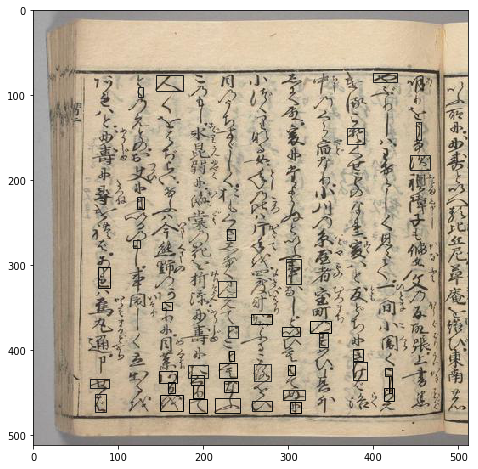

In [80]:
show_result(train_images[index], gt_train_bboxes)

/home/kaito/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


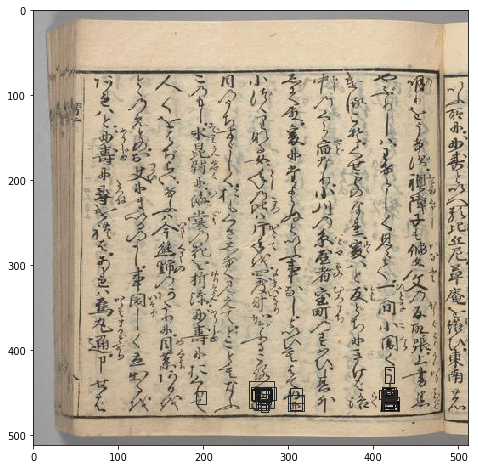

In [81]:
show_result(train_images[index], pred_train_bboxes)

/home/kaito/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


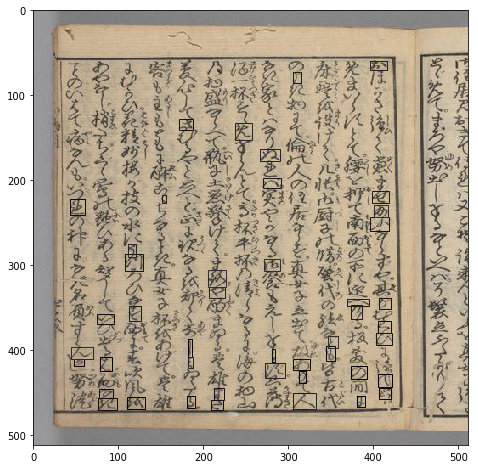

In [82]:
show_result(validation_images[index], gt_validation_bboxes)

/home/kaito/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


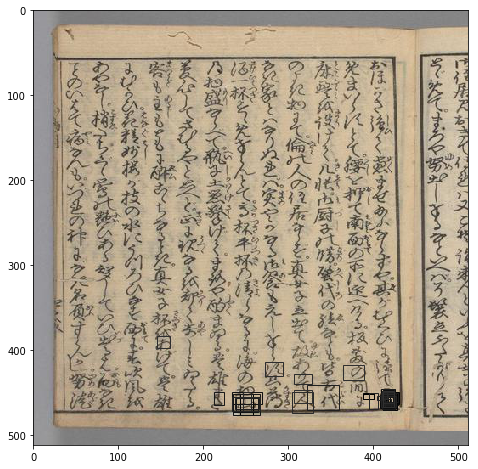

In [83]:
show_result(validation_images[index], pred_validation_bboxes)

/home/kaito/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


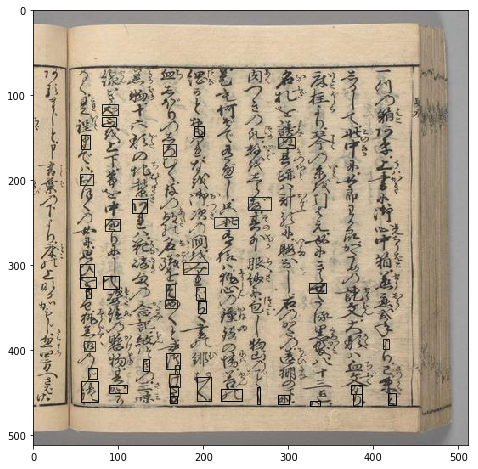

In [84]:
show_result(test_images1[index], gt_test_bboxes1)

/home/kaito/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


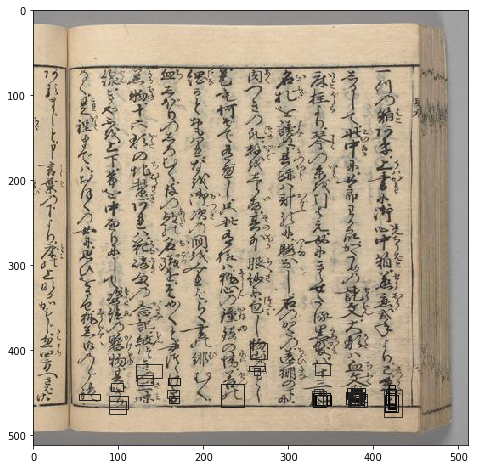

In [85]:
show_result(test_images1[index], pred_test_bboxes1)

/home/kaito/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


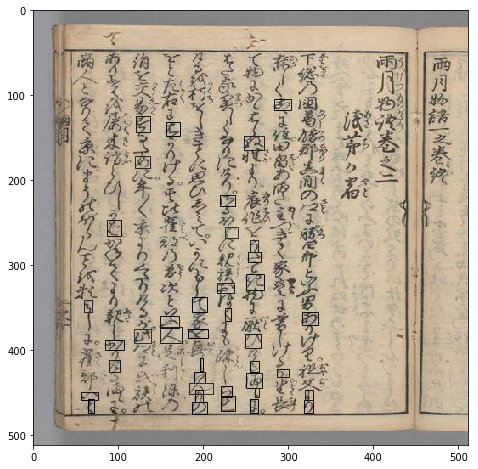

In [87]:
show_result(test_images2[index], gt_test_bboxes2)

/home/kaito/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


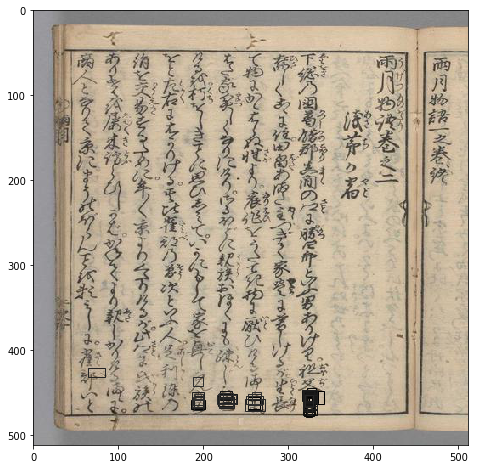

In [88]:
show_result(test_images2[index], pred_test_bboxes2)